In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score , auc , roc_curve
from sklearn.preprocessing import label_binarize
import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

In [2]:
X_test = pd.read_csv  ('POS Spliting Data\\X_test.csv')  ['Data']

y_test = pd.read_csv  ('POS Spliting Data\\y_test.csv')  ['Data']

X_val = pd.read_csv   ('POS Spliting Data\\X_val.csv')   ['Data']

y_val = pd.read_csv   ('POS Spliting Data\\y_val.csv')   ['Data']


In [3]:
Models = {
    'nb'  :  joblib.load('POS_naive_bayes_pipeline.joblib'),
    'svm' :  joblib.load('POS_svm_pipeline.joblib'),
    'lr'  :  joblib.load('POS_logistic_regression_pipeline.joblib'),
    'rf'  :  joblib.load('POS_random_forest_pipeline.joblib'),
    'kn'  :  joblib.load('POS_knn_pipeline.joblib'),
    'dt'  :  joblib.load('POS_DT_pipeline.joblib')
}

In [4]:
def Merge_Others(li):
    templi = []
    for label in li:
        if label.startswith('OTHER'):
            templi.append('OTHER')
        else:
            templi.append(label)

    return templi

In [5]:
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test) 
y_val  = label_encoder.transform(y_val) 


In [6]:
Models_Predictions = {}
def Get_Predictions(model , model_name):
    
    predictions     = model.predict(X_test)
    val_predictions = model.predict(X_val)
    
    val_predictions = Merge_Others(val_predictions)
    predictions     = Merge_Others(predictions)
    
 
    predictions     = label_encoder.transform(predictions) 
    val_predictions = label_encoder.transform(val_predictions) 

    Models_Predictions[model_name] = {'test' : list(predictions) , 'val' : list(val_predictions)}
    
    print(f"{ model_name} Done")
    print('-------------------------')

In [7]:
for model in list(Models.keys()):
    Get_Predictions(Models[model],model)

nb Done
-------------------------
svm Done
-------------------------
lr Done
-------------------------
rf Done
-------------------------
kn Done
-------------------------
dt Done
-------------------------


In [8]:
def Print_SomeEvaluteMethods(test_predictions, val_predictions):
    # Calculate metrics for the validation set
    accuracy_val = accuracy_score(y_val, val_predictions)
    balanced_accuracy_val = balanced_accuracy_score(y_val, val_predictions)
    f1_val = f1_score(y_val, val_predictions, average='weighted')  # Use 'weighted' for multiclass
    recall_val = recall_score(y_val, val_predictions, average='weighted')
    precision_val = precision_score(y_val, val_predictions, average='weighted')

    # Calculate metrics for the test set
    accuracy_test = accuracy_score(y_test, test_predictions)
    balanced_accuracy_test = balanced_accuracy_score(y_test, test_predictions)
    f1_test = f1_score(y_test, test_predictions, average='weighted')  # Use 'weighted' for multiclass
    recall_test = recall_score(y_test, test_predictions, average='weighted')
    precision_test = precision_score(y_test, test_predictions, average='weighted')

    print('------------------- Validation Set -----------------')
    print(f'Accuracy: {accuracy_val*100:.4f}')
    print(f'Balanced Accuracy: {balanced_accuracy_val*100:.4f}')
    print(f'F1 Score: {f1_val:.4f}')
    print(f'Recall: {recall_val:.4f}')
    print(f'Precision: {precision_val:.4f}')

    print('--------------------- Test Set ---------------------')
    print(f'Accuracy: {accuracy_test*100:.4f}')
    print(f'Balanced Accuracy: {balanced_accuracy_test*100:.4f}')
    print(f'F1 Score: {f1_test:.4f}')
    print(f'Recall: {recall_test:.4f}')
    print(f'Precision: {precision_test:.4f}')

    print('-------------------------------------------------------')


In [9]:
def Print_ROC_Curve(predictions,actual):
    
    y_p = label_binarize(predictions, classes=np.unique(predictions))
    y_t = label_binarize(actual, classes=np.unique(actual))
 
    classes = np.unique(actual)
 
    # Compute ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = y_t.shape[1]
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_t[:, i], y_p[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])



    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))


    # Plot macro-average ROC curve
    plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})', color='navy', linestyle=':', linewidth=4)

    # Plot ROC curve for each class
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

    # Plot the random chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Set plot properties
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
 
    print('---------------------------------------------------')


In [10]:
def Model_evaluate(model):
    
    test_predictions = Models_Predictions[model]['test']
    val_predictions  = Models_Predictions[model]['val']
    
    Print_SomeEvaluteMethods(test_predictions,val_predictions)
    
    Print_ROC_Curve ( test_predictions , y_test )
    Print_ROC_Curve ( val_predictions  , y_val  )

In [11]:
# Create a dataframe to store the predictions of the individual models
ensemble_df = pd.DataFrame({
    'nb' :   Models_Predictions['nb'] ['test'],
    'svm':   Models_Predictions['svm']['test'],
    'lr' :   Models_Predictions['lr'] ['test'],
    'rf' :   Models_Predictions['rf'] ['test'],
    'kn' :   Models_Predictions['kn'] ['test'],
    'dt' :   Models_Predictions['dt'] ['test']
})

#Create a Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest model on the predictions of the individual models
random_forest_model.fit(ensemble_df, y_test)

# Make predictions using the Random Forest model
ensemble_predictions_rf_test = random_forest_model.predict(ensemble_df)

In [12]:
# Create a dataframe to store the predictions of the individual models
ensemble_df = pd.DataFrame({
    'nb' :   Models_Predictions['nb'] ['val'],
    'svm':   Models_Predictions['svm']['val'],
    'lr' :   Models_Predictions['lr'] ['val'],
    'rf' :   Models_Predictions['rf'] ['val'],
    'kn' :   Models_Predictions['kn'] ['val'],
    'dt' :   Models_Predictions['dt'] ['val']
})

#Create a Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest model on the predictions of the individual models
random_forest_model.fit(ensemble_df, y_val)

# Make predictions using the Random Forest model
ensemble_predictions_rf_val = random_forest_model.predict(ensemble_df)

------------------- Validation Set -----------------
Accuracy: 21.6023
Balanced Accuracy: 12.3478
F1 Score: 0.2283
Recall: 0.2160
Precision: 0.3442
--------------------- Test Set ---------------------
Accuracy: 21.5946
Balanced Accuracy: 12.4396
F1 Score: 0.2265
Recall: 0.2159
Precision: 0.3225
-------------------------------------------------------


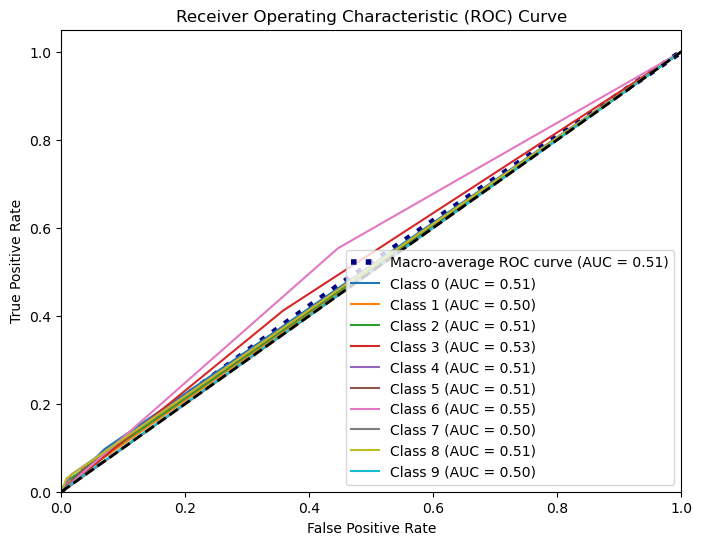

---------------------------------------------------


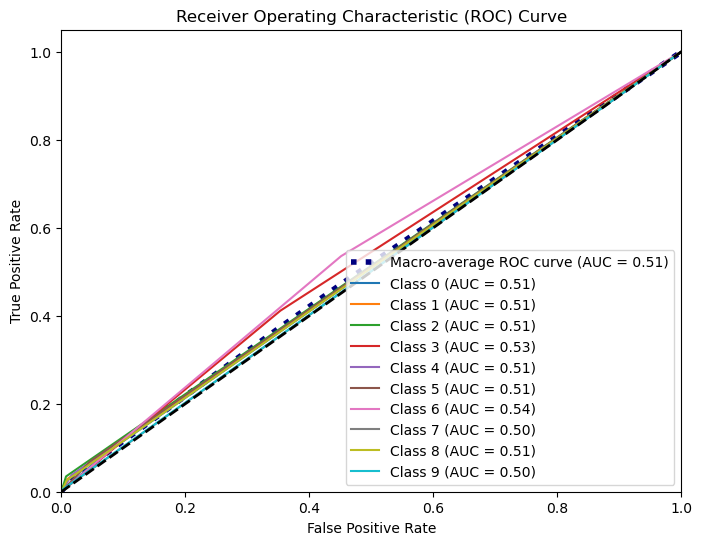

---------------------------------------------------


In [13]:
Model_evaluate('nb')

------------------- Validation Set -----------------
Accuracy: 40.2898
Balanced Accuracy: 11.4223
F1 Score: 0.2998
Recall: 0.4029
Precision: 0.3252
--------------------- Test Set ---------------------
Accuracy: 40.2301
Balanced Accuracy: 11.5036
F1 Score: 0.3002
Recall: 0.4023
Precision: 0.3280
-------------------------------------------------------


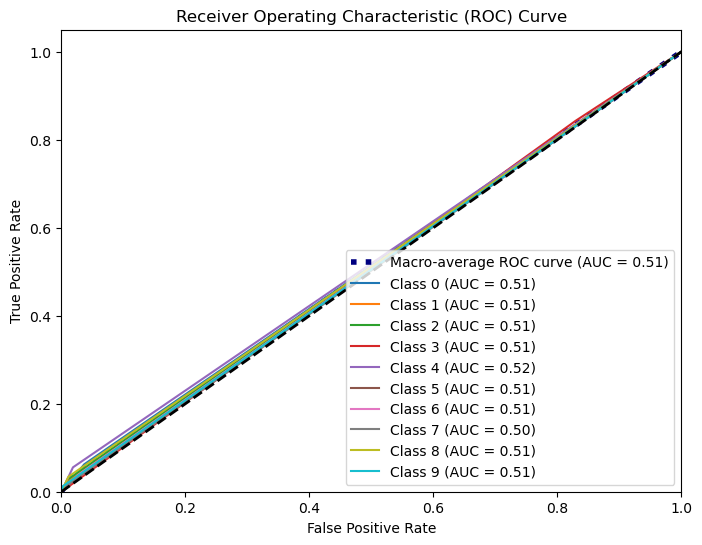

---------------------------------------------------


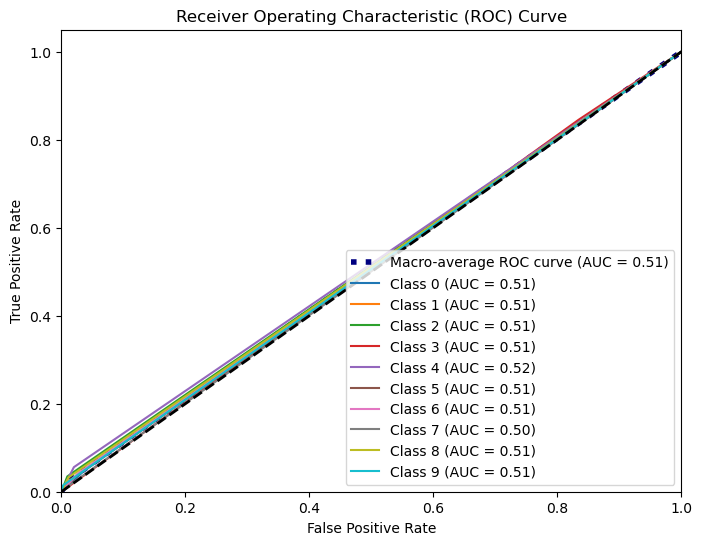

---------------------------------------------------


In [14]:
Model_evaluate('svm')

------------------- Validation Set -----------------
Accuracy: 40.4224
Balanced Accuracy: 11.4058
F1 Score: 0.3020
Recall: 0.4042
Precision: 0.3099
--------------------- Test Set ---------------------
Accuracy: 40.2156
Balanced Accuracy: 11.1969
F1 Score: 0.2998
Recall: 0.4022
Precision: 0.3091
-------------------------------------------------------


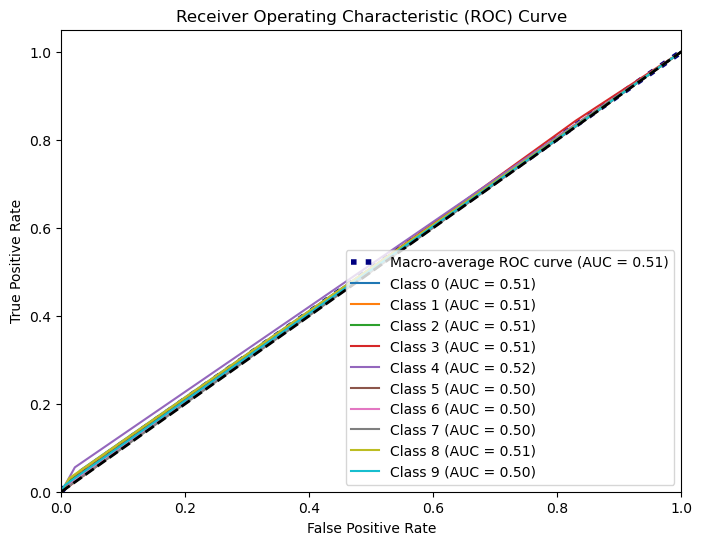

---------------------------------------------------


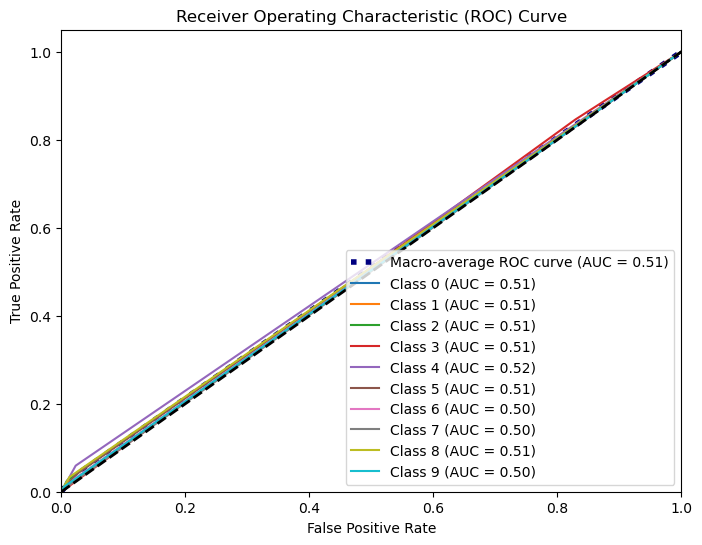

---------------------------------------------------


In [15]:
Model_evaluate('lr')

------------------- Validation Set -----------------
Accuracy: 38.5828
Balanced Accuracy: 10.8709
F1 Score: 0.2896
Recall: 0.3858
Precision: 0.2982
--------------------- Test Set ---------------------
Accuracy: 38.8916
Balanced Accuracy: 11.0107
F1 Score: 0.2920
Recall: 0.3889
Precision: 0.2993
-------------------------------------------------------


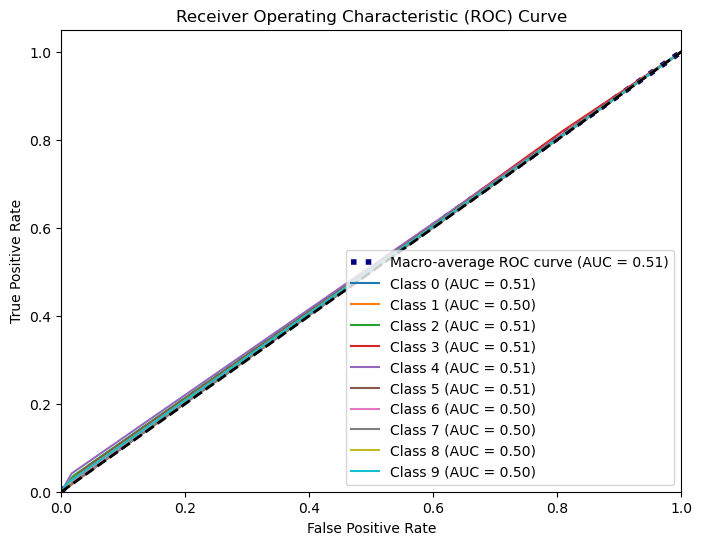

---------------------------------------------------


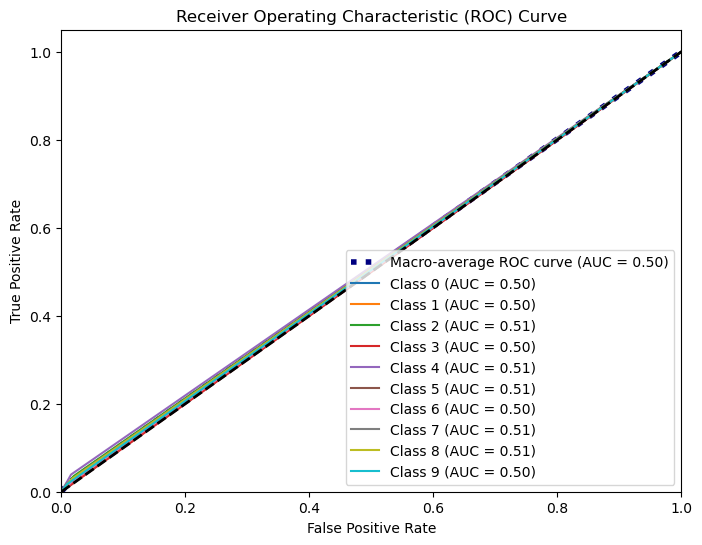

---------------------------------------------------


In [16]:
Model_evaluate('rf')

------------------- Validation Set -----------------
Accuracy: 37.6184
Balanced Accuracy: 10.6672
F1 Score: 0.2815
Recall: 0.3762
Precision: 0.3054
--------------------- Test Set ---------------------
Accuracy: 37.8666
Balanced Accuracy: 10.9524
F1 Score: 0.2832
Recall: 0.3787
Precision: 0.3039
-------------------------------------------------------


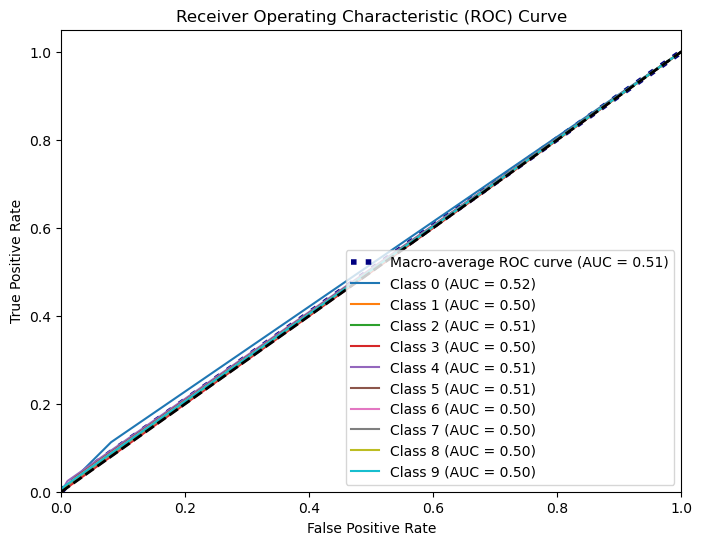

---------------------------------------------------


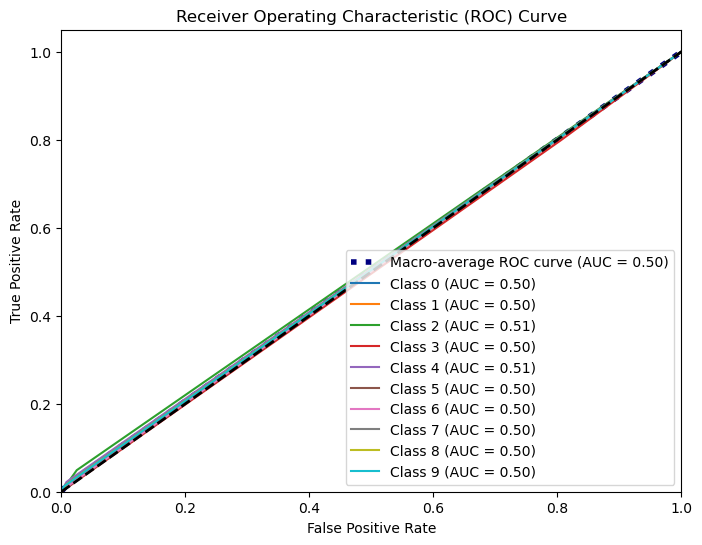

---------------------------------------------------


In [17]:
Model_evaluate('kn')

------------------- Validation Set -----------------
Accuracy: 37.7655
Balanced Accuracy: 10.4457
F1 Score: 0.2834
Recall: 0.3777
Precision: 0.2886
--------------------- Test Set ---------------------
Accuracy: 38.0788
Balanced Accuracy: 10.6856
F1 Score: 0.2858
Recall: 0.3808
Precision: 0.2882
-------------------------------------------------------


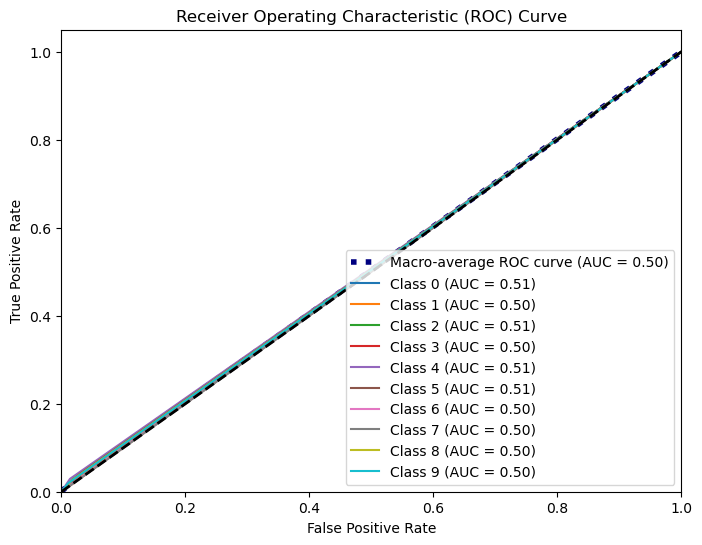

---------------------------------------------------


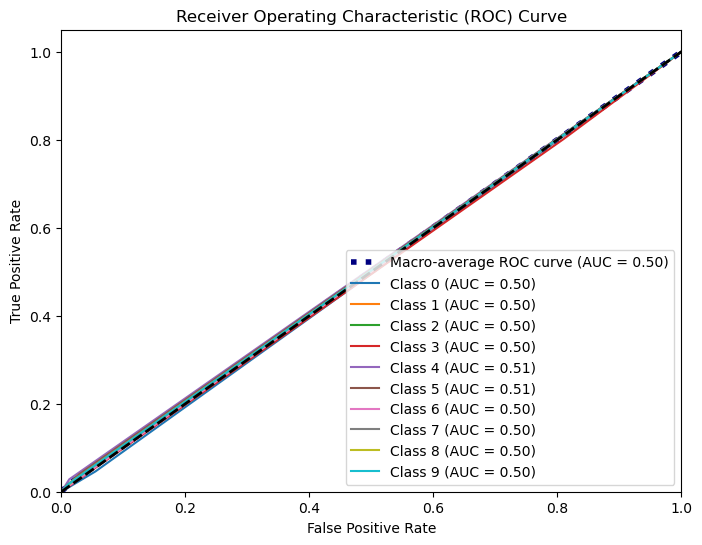

---------------------------------------------------


In [18]:
Model_evaluate('dt')

------------------- Validation Set -----------------
Accuracy: 50.4352
Balanced Accuracy: 18.3557
F1 Score: 0.3984
Recall: 0.5044
Precision: 0.6143
--------------------- Test Set ---------------------
Accuracy: 50.5957
Balanced Accuracy: 18.4168
F1 Score: 0.4009
Recall: 0.5060
Precision: 0.6170
-------------------------------------------------------


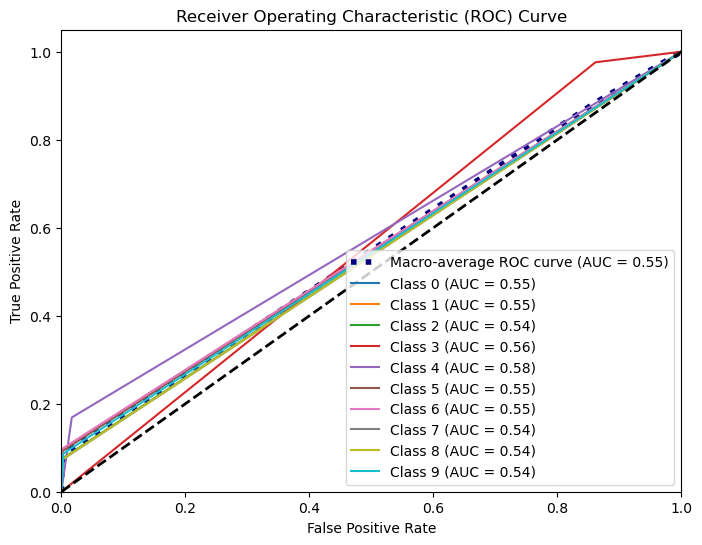

---------------------------------------------------


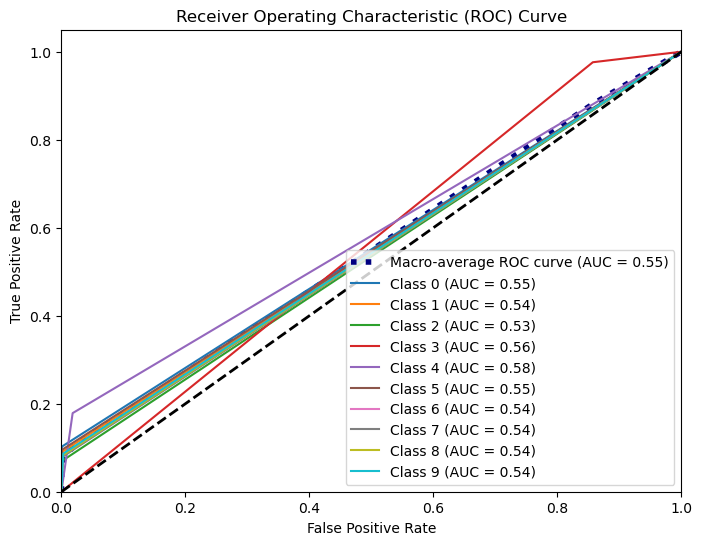

---------------------------------------------------


In [19]:
Print_SomeEvaluteMethods(ensemble_predictions_rf_test,ensemble_predictions_rf_val)

Print_ROC_Curve(ensemble_predictions_rf_val  , y_val)

Print_ROC_Curve(ensemble_predictions_rf_test , y_test)